In [17]:
# Requirements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import math
from sklearn.model_selection import train_test_split
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
import torch.backends.cudnn as cudnn
import torch.optim
import os
import sys
import argparse
import time
import numpy as np
from PIL import Image
from torchvision import transforms
import time
import cv2

In [3]:
path_Dark = './Dataset/DarkPair/Low'
path_lol = './Dataset/lol_dataset/lol_dataset/our485/low'
path_low_ex ='./Dataset/lol_dataset/lol_dataset/eval15/low'

## Loading Data

In [4]:
def array(all_paths):
    all_array = []
    for path in all_paths:
        file_list = os.listdir(path)
        image_files = [f for f in file_list if f.endswith('.png')]
        for image_file in image_files:
            image_path = os.path.join(path, image_file)
            image = Image.open(image_path)
            all_array.append(image)
    return all_array

In [5]:
all_paths = [path_Dark,path_lol,path_low_ex] 
image_data = array(all_paths)

## Resize data

In [6]:
IMAGE_SIZE = 256
transform = transforms.Compose([
            transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            transforms.ToTensor()
        ]) 
a = []
for i in image_data:
    a.append(transform(i))
tensor = torch.tensor(np.stack(a))
tensor.size()

torch.Size([1289, 3, 256, 256])

In [7]:
dataloader = DataLoader(tensor, batch_size=16, shuffle=True, drop_last=True)

In [8]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

## Model Building

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np

class enhance_net_nopool(nn.Module):

    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        number_f = 32
        self.e_conv1 = nn.Conv2d(3,number_f,3,1,1,bias=True) 
        self.e_conv2 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv3 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv4 = nn.Conv2d(number_f,number_f,3,1,1,bias=True) 
        self.e_conv5 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
        self.e_conv6 = nn.Conv2d(number_f*2,number_f,3,1,1,bias=True) 
        self.e_conv7 = nn.Conv2d(number_f*2,24,3,1,1,bias=True) 

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):

        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))

        x5 = self.relu(self.e_conv5(torch.cat([x3,x4],1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2,x5],1)))

        x_r = F.tanh(self.e_conv7(torch.cat([x1,x6],1)))
        r1,r2,r3,r4,r5,r6,r7,r8 = torch.split(x_r, 3, dim=1)

        x = x + r1*(torch.pow(x,2)-x)
        x = x + r2*(torch.pow(x,2)-x)
        x = x + r3*(torch.pow(x,2)-x)
        enhance_image_1 = x + r4*(torch.pow(x,2)-x)		
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1,2)-enhance_image_1)		
        x = x + r6*(torch.pow(x,2)-x)	
        x = x + r7*(torch.pow(x,2)-x)
        enhance_image = x + r8*(torch.pow(x,2)-x)
        r = torch.cat([r1,r2,r3,r4,r5,r6,r7,r8],1)
        return enhance_image_1,enhance_image,r

## Loss Metric

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torchvision.models.vgg import vgg16
import numpy as np
class L_color(nn.Module):

    def __init__(self):
        super(L_color, self).__init__()

    def forward(self, x):

        b,c,h,w = x.shape

        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Drg = torch.pow(mr-mg,2)
        Drb = torch.pow(mr-mb,2)
        Dgb = torch.pow(mb-mg,2)
        k = torch.pow(torch.pow(Drg,2) + torch.pow(Drb,2) + torch.pow(Dgb,2),0.5)
        return k

class L_spa(nn.Module):

    def __init__(self):
        super(L_spa, self).__init__()
        
        kernel_left = torch.FloatTensor( [[0,0,0],[-1,1,0],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_right = torch.FloatTensor( [[0,0,0],[0,1,-1],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_up = torch.FloatTensor( [[0,-1,0],[0,1, 0 ],[0,0,0]]).cuda().unsqueeze(0).unsqueeze(0)
        kernel_down = torch.FloatTensor( [[0,0,0],[0,1, 0],[0,-1,0]]).cuda().unsqueeze(0).unsqueeze(0)
        self.weight_left = nn.Parameter(data=kernel_left, requires_grad=False)
        self.weight_right = nn.Parameter(data=kernel_right, requires_grad=False)
        self.weight_up = nn.Parameter(data=kernel_up, requires_grad=False)
        self.weight_down = nn.Parameter(data=kernel_down, requires_grad=False)
        self.pool = nn.AvgPool2d(4)
    def forward(self, org , enhance ):
        b,c,h,w = org.shape

        org_mean = torch.mean(org,1,keepdim=True)
        enhance_mean = torch.mean(enhance,1,keepdim=True)

        org_pool =  self.pool(org_mean)
        enhance_pool = self.pool(enhance_mean)

        weight_diff =torch.max(torch.FloatTensor([1]).cuda() + 
                               10000*torch.min(org_pool - torch.FloatTensor([0.3]).cuda(),
                                                                               torch.FloatTensor([0]).cuda()),
                               torch.FloatTensor([0.5]).cuda())
        E_1 = torch.mul(torch.sign(enhance_pool - torch.FloatTensor([0.5]).cuda()) ,enhance_pool-org_pool)


        D_org_letf = F.conv2d(org_pool , self.weight_left, padding=1)
        D_org_right = F.conv2d(org_pool , self.weight_right, padding=1)
        D_org_up = F.conv2d(org_pool , self.weight_up, padding=1)
        D_org_down = F.conv2d(org_pool , self.weight_down, padding=1)

        D_enhance_letf = F.conv2d(enhance_pool , self.weight_left, padding=1)
        D_enhance_right = F.conv2d(enhance_pool , self.weight_right, padding=1)
        D_enhance_up = F.conv2d(enhance_pool , self.weight_up, padding=1)
        D_enhance_down = F.conv2d(enhance_pool , self.weight_down, padding=1)

        D_left = torch.pow(D_org_letf - D_enhance_letf,2)
        D_right = torch.pow(D_org_right - D_enhance_right,2)
        D_up = torch.pow(D_org_up - D_enhance_up,2)
        D_down = torch.pow(D_org_down - D_enhance_down,2)
        E = (D_left + D_right + D_up +D_down)

        return E
class L_exp(nn.Module):

    def __init__(self,patch_size,mean_val):
        super(L_exp, self).__init__()
        # print(1)
        self.pool = nn.AvgPool2d(patch_size)
        self.mean_val = mean_val
    def forward(self, x ):

        b,c,h,w = x.shape
        x = torch.mean(x,1,keepdim=True)
        mean = self.pool(x)

        d = torch.mean(torch.pow(mean- torch.FloatTensor([self.mean_val] ).cuda(),2))
        return d
        
class L_TV(nn.Module):
    def __init__(self,TVLoss_weight=1):
        super(L_TV,self).__init__()
        self.TVLoss_weight = TVLoss_weight

    def forward(self,x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h =  (x.size()[2]-1) * x.size()[3]
        count_w = x.size()[2] * (x.size()[3] - 1)
        h_tv = torch.pow((x[:,:,1:,:]-x[:,:,:h_x-1,:]),2).sum()
        w_tv = torch.pow((x[:,:,:,1:]-x[:,:,:,:w_x-1]),2).sum()
        return self.TVLoss_weight*2*(h_tv/count_h+w_tv/count_w)/batch_size

class Sa_Loss(nn.Module):
    def __init__(self):
        super(Sa_Loss, self).__init__()
        # print(1)
    def forward(self, x ):
        # self.grad = np.ones(x.shape,dtype=np.float32)
        b,c,h,w = x.shape
        # x_de = x.cpu().detach().numpy()
        r,g,b = torch.split(x , 1, dim=1)
        mean_rgb = torch.mean(x,[2,3],keepdim=True)
        mr,mg, mb = torch.split(mean_rgb, 1, dim=1)
        Dr = r-mr
        Dg = g-mg
        Db = b-mb
        k =torch.pow( torch.pow(Dr,2) + torch.pow(Db,2) + torch.pow(Dg,2),0.5)
        k = torch.mean(k)
        return k

class perception_loss(nn.Module):
    def __init__(self):
        super(perception_loss, self).__init__()
        features = vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential() 
        self.to_relu_2_2 = nn.Sequential() 
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        return h_relu_4_3

## Training 

In [14]:
os.environ['CUDA_VISIBLE_DEVICES']='0'

DCE_net = enhance_net_nopool().cuda()

DCE_net.apply(weights_init)
L_color = L_color()
L_spa = L_spa()

L_exp = L_exp(16,0.6)
L_TV = L_TV()

optimizer = torch.optim.Adam(DCE_net.parameters(), lr=0.001, weight_decay=0)

DCE_net.train()
Total_loss = []
loss_col_array = []
loss_spa_array = []
loss_exp_array = []
loss_TV_array = []
num_epochs = 50
for epoch in range(num_epochs):
    for iteration, img_lowlight in enumerate(dataloader):

        img_lowlight = img_lowlight.cuda()

        enhanced_image_1,enhanced_image,A  = DCE_net(img_lowlight)

        Loss_TV = 200*L_TV(A)

        loss_spa = torch.mean(L_spa(enhanced_image, img_lowlight))

        loss_col = 5*torch.mean(L_color(enhanced_image))

        loss_exp = 10*torch.mean(L_exp(enhanced_image))

        loss =  Loss_TV + loss_spa + loss_col + loss_exp

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(DCE_net.parameters(),0.1)
        optimizer.step()
        Total_loss.append(loss.item())
        loss_col_array.append(loss_col.item())
        loss_spa_array.append(loss_spa.item())
        loss_TV_array.append(Loss_TV.item())
        loss_exp_array.append(loss_exp.item())
    print("Loss at epoch", epoch+1, ":", loss.item(), Loss_TV.item(), loss_spa.item(), loss_col.item(), loss_exp.item())
torch.save(DCE_net.state_dict(), './' + "Epoch_new" + str(epoch) + '.pth') 
    #         if ((iteration+1) % config.snapshot_iter) == 0:

/tmp/ipykernel_93/1703496064.py:40: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(DCE_net.parameters(),0.1)


Loss at epoch 1 : 1.0837924480438232 0.08935140818357468 0.034912027418613434 0.09667186439037323 0.8628571629524231
Loss at epoch 2 : 0.6358691453933716 0.06938876211643219 0.03920448198914528 0.08539126813411713 0.4418846368789673
Loss at epoch 3 : 0.5660281181335449 0.08968905359506607 0.03274624049663544 0.08160162717103958 0.36199119687080383
Loss at epoch 4 : 0.7300400733947754 0.07755868136882782 0.03091483749449253 0.1287144124507904 0.49285218119621277
Loss at epoch 5 : 0.4860974848270416 0.08720796555280685 0.035247839987277985 0.04504865035414696 0.31859302520751953
Loss at epoch 6 : 0.7498214244842529 0.08150489628314972 0.03326767683029175 0.12607334554195404 0.5089755058288574
Loss at epoch 7 : 0.6075959205627441 0.06301135569810867 0.033694613724946976 0.07571135461330414 0.43517857789993286
Loss at epoch 8 : 0.6171524524688721 0.10594173520803452 0.0365225225687027 0.1618494838476181 0.31283873319625854
Loss at epoch 9 : 0.6914478540420532 0.13328740000724792 0.03935937

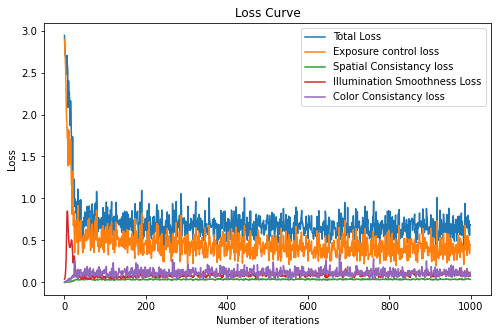

In [31]:
plt.figure(figsize = (8,5))
plt.plot(list(range(0,1000)),Total_loss[:1000], label = 'Total Loss')
plt.plot(list(range(0,1000)),loss_exp_array[:1000], label = "Exposure control loss")
plt.plot(list(range(0,1000)),loss_spa_array[:1000], label = "Spatial Consistancy loss")
plt.plot(list(range(0,1000)),loss_TV_array[:1000], label = "Illumination Smoothness Loss")
plt.plot(list(range(0,1000)),loss_col_array[:1000], label = "Color Consistancy loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

## Testing

In [17]:
def lowlight(image_path):
    os.environ['CUDA_VISIBLE_DEVICES']='0'
    data_lowlight = Image.open(image_path)
    data_lowlight = data_lowlight.convert('RGB')
    data_lowlight = (np.asarray(data_lowlight)/255.0)
    data_lowlight = torch.from_numpy(data_lowlight).float()
    data_lowlight = data_lowlight.permute(2,0,1)
    data_lowlight = data_lowlight.cuda().unsqueeze(0)

    DCE_net = enhance_net_nopool().cuda()
    DCE_net.load_state_dict(torch.load('./Epoch99.pth'))
    start = time.time()
    _,enhanced_image,_ = DCE_net(data_lowlight)

    end_time = (time.time() - start)
    print(end_time)
    image_path = image_path.replace('test_data','result')
    result_path = image_path
    if not os.path.exists(image_path.replace('/'+image_path.split("/")[-1],'')):
        os.makedirs(image_path.replace('/'+image_path.split("/")[-1],''))

    torchvision.utils.save_image(enhanced_image, './x.png')
    print(result_path)

with torch.no_grad():
    filePath = './Dataset/lol_dataset/lol_dataset/our485/low/100.png'

    print(filePath)
    lowlight(filePath)

./Dataset/lol_dataset/lol_dataset/our485/low/100.png
0.039609432220458984
./Dataset/lol_dataset/lol_dataset/our485/low/100.png


/opt/conda/lib/python3.9/site-packages/torch/nn/functional.py:1794: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Denoising

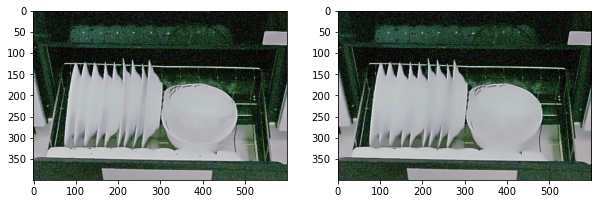

In [35]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('x.png')
dst = cv.fastNlMeansDenoisingColored(img,None,10,10,7,21)
plt.subplot(121),plt.imshow(img)
plt.subplot(122),plt.imshow(dst)
plt.show()

In [36]:
image = Image.fromarray(dst)

# Save the image as a file
image.save("x.png")

## YOLO integration

In [38]:
CONFIDENCE = 0.2
SCORE_THRESHOLD = 0.2
IOU_THRESHOLD = 0.2
config_path = "yolov3.cfg"
weights = "yolov3.weights"
labels = open("coco.names").read().strip().split("\n")
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [39]:
net = cv2.dnn.readNetFromDarknet(config_path, weights)

In [40]:
def model_output(path_name):
    image = cv2.imread(path_name)
    file_name = os.path.basename(path_name)
    filename,ext = file_name.split(".")
    h,w = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1/255.0, (416,416), swapRB = True, crop = False)
   
    net.setInput(blob)
    ln = net.getLayerNames()
    layers_indices = net.getUnconnectedOutLayers()
    ln = [ln[i[0] - 1] for i in [layers_indices]]
    
    layer_outputs = net.forward(ln)
    boxes, confidences, class_ids = [], [], []
    for output in layer_outputs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence>CONFIDENCE:
                box = detection[:4]*np.array([w,h,w,h])
                (centerX, centerY, width, height) = box.astype("int")
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
                boxes.append([x,y,int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    return boxes, confidences, class_ids


## Object detection

In [41]:
def detection_recognition(path_name):
    image = cv2.imread(path_name)
    boxes, confidences, class_ids = model_output(path_name)
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, SCORE_THRESHOLD, IOU_THRESHOLD)
    font_scale = 1
    thickness = 1
    if len(idxs)>0:
        for i in idxs.flatten():
            x,y = boxes[i][0], boxes[i][1]
            w,h = boxes[i][2], boxes[i][3]
            color = [int(c) for c in colors[class_ids[i]]]
            cv2.rectangle(image, (x,y), (x+w, y+h), color = color, thickness= thickness)
            text = f"{labels[class_ids[i]]}: {confidences[i]:.2f}"
            (text_width, text_height) = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, fontScale=font_scale, thickness=thickness)[0]
            text_offset_x = x
            text_offset_y = y - 5
            box_coords = ((text_offset_x, text_offset_y), (text_offset_x + text_width + 2, text_offset_y - text_height))
            overlay = image.copy()
            cv2.rectangle(overlay, box_coords[0], box_coords[1], color=color, thickness=cv2.FILLED)
            image = cv2.addWeighted(overlay, 0.6, image, 0.4, 0)#add two copies to one and the numbers define blending percent
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=font_scale, color=(0, 0, 0), thickness=thickness)
    %matplotlib inline
    plt.rcParams['figure.figsize'] = (10.0, 10.0)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

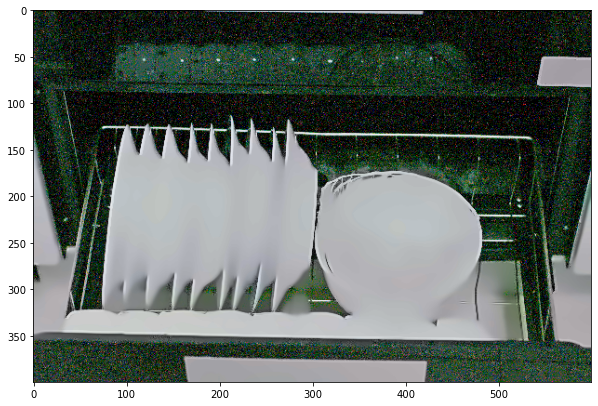

In [42]:
detection_recognition("x.png")